In [1]:
import pandas as pd
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)

### Load curated data. Exam price distribution.

In [2]:
data_path = "src/data_sourcing/data_curated.csv"
full_data_path = os.path.join(os.getcwd(), data_path)
df = pd.read_csv(full_data_path)

(array([ 0., 18., 79., 52., 42., 40., 25., 20.,  8., 12.,  5.,  3.,  8.,
         5.,  0.,  6.,  2.,  1.,  1.,  4.,  3.,  2.,  4.,  3.,  0.,  2.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  2.,  0.,
         0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
        390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510,
        520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640,
        650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770,
 

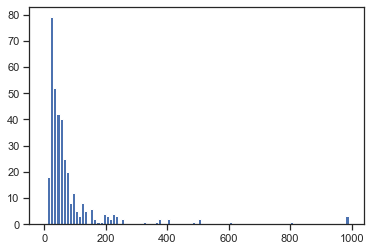

In [3]:
bins = np.arange(0,1000,10)
prices = np.array(df['average_sale_price']).reshape(-1,1)
plt.hist(np.clip(prices,bins[0],bins[-1]), bins)

### Discretize price into discrete price ranges. Applying application specific assumption that five price ranges is useful.

In [109]:
price_bins = np.exp(np.log(np.max(prices)/np.min(prices))/5*np.array([0,1,2,3,4,5]))*np.min(prices)
# print the range of price bins
print(price_bins)
# assign price_bin to each item
def get_price_bin(row):
    avg_price = row.average_sale_price
    if avg_price >= price_bins[0] and avg_price < price_bins[1]:
        return 1
    if avg_price >= price_bins[1] and avg_price < price_bins[2]:
        return 2
    if avg_price >= price_bins[2] and avg_price < price_bins[3]:
        return 3
    if avg_price >= price_bins[3] and avg_price < price_bins[4]:
        return 4
    if avg_price >= price_bins[4] and avg_price < price_bins[5]:
        return 5
df["price_bin"] = df.apply(get_price_bin, axis=1)
# see some simple stats
df[['price_bin','average_sale_price']].groupby(['price_bin'], as_index=False).agg(['min','max','std','mean','size'])

[  14.           38.31687838  104.87022635  287.02140777  785.55459817
 2150.        ]


average_sale_price                                           
                         min          max         std         mean size
price_bin                                                              
1                  14.000000    37.000000    5.621984    26.856773  146
2                  38.428571   101.000000   16.598244    60.913357  153
3                 108.000000   257.333333   45.036885   168.427053   46
4                 322.400000   600.000000   85.537626   432.390000   10
5                 800.000000  2150.000000  603.494736  1388.625000    4

### Exam search volume distribution and apply normalization.

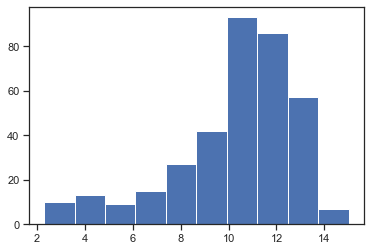

In [5]:
plt.hist(np.log(df['search_volume']))
log_vol_max = np.max(np.log(df['search_volume']))
log_vol_min = np.min(np.log(df['search_volume']))
def get_search_volume_normalized(row):
    search_volume = row.search_volume
    return (math.log(search_volume)-log_vol_min) / (log_vol_max-log_vol_min)
df["search_volume_normalized"] = df.apply(get_search_volume_normalized, axis=1)

### Visualize relationshp between price bin and features

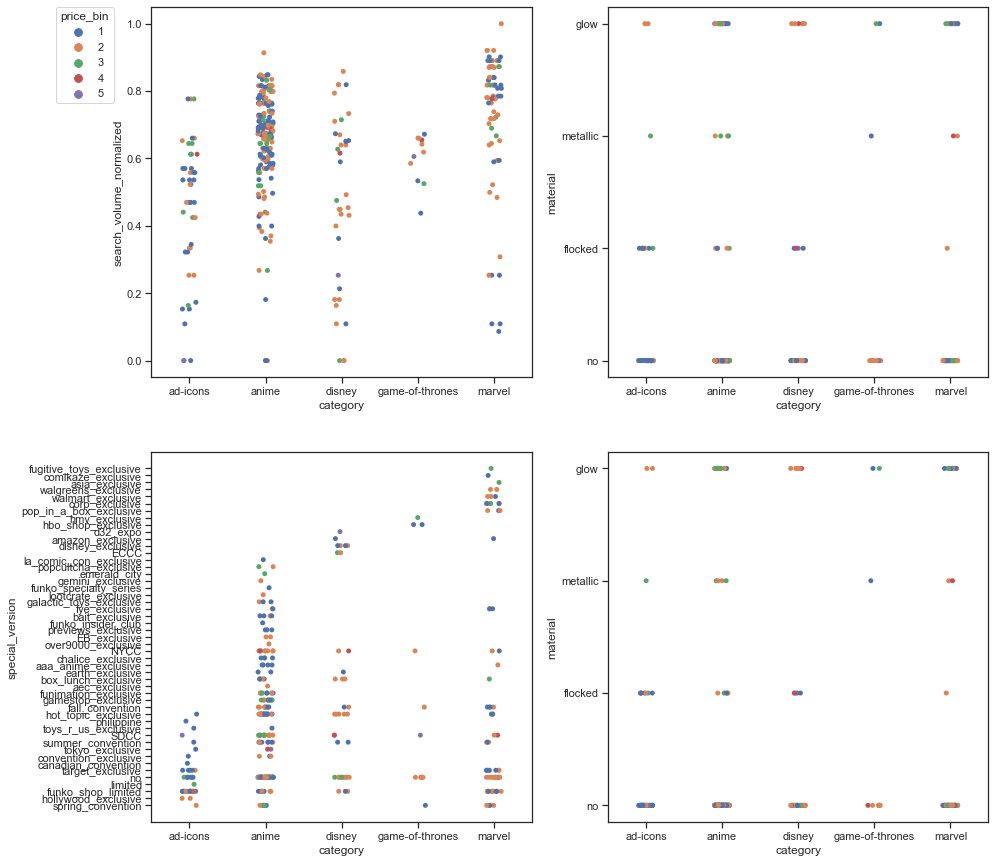

In [110]:
fig, axes = plt.subplots(2,2,figsize = (15,15))
sns.stripplot(ax=axes[0][0], x="category", y="search_volume_normalized", hue='price_bin',data=df)
sns.stripplot(ax=axes[0][1], x="category", y="material", hue='price_bin', data=df)
sns.stripplot(ax=axes[1][0], x="category", y="special_version", hue='price_bin', data=df)
sns.stripplot(ax=axes[1][1], x="category", y="material", hue='price_bin', data=df)
axes[0][0].legend(title='price_bin', bbox_to_anchor=(-.25, 1), loc=2, borderaxespad=0.)
axes[0][1].legend([],[], frameon=False)
axes[1][0].legend([],[], frameon=False)
axes[1][1].legend([],[], frameon=False)

### Preprocess categorical features using one hot encoding.

In [113]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_features = ['search_volume_normalized']
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
categorical_features = ['category', 'material', 'special_version']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)])
X = preprocessor.fit_transform(df)
y = df['price_bin']

In [285]:
pd.set_option('display.max_colwidth', None)
df[df['price_bin']==5]

,product_name,product_ticker,category,release_date,sale_count,average_sale_price,topic,material,special_version,search_volume,price_bin,search_volume_normalized
33,Funko Pop! Ad Icons Otter Pops Louie-Bloo Raspberry SDCC Figure #48,F-POAIOPL49,ad-icons,7/17/2019,1,800.0,louie-bloo raspberry,no,SDCC,10,5,0.000000
141,Funko Pop! Animation Dragonball Z Planet Arlia Vegeta Toy Tokyo NYCC Figure #10,F-POADZPA10,anime,NaN,3,2150.0,vegeta,no,tokyo_exclusive,164000,5,0.763764
259,Funko Pop! Disney Toy Story Lotso (Flocked) D23 Expo Figure #13,F-PODTSL13,disney,1/1/2011,2,1577.5,toy story lotso,flocked,d32_expo,250,5,0.253318
282,Funko Pop! Game Of Thrones Ned Stark (Headless) (Bloody) SDCC Figure #02,F-POGOTNS02,game-of-thrones,2/12/2013,3,1027.0,ned stark,no,SDCC,22000,5,0.605674


### Stratified KFold split

In [114]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

### Custom Metric Class

In [241]:
from sklearn.metrics import precision_score, recall_score, f1_score

class MyMetric(object):
    
    def __init__(self, avg_method='weighted'):
        self.avg_method=avg_method
        self.avg_train_precs = []
        self.avg_train_recalls = []
        self.avg_train_f1s = []
        self.avg_test_precs = []
        self.avg_test_recalls = []
        self.avg_test_f1s = []
        self.per_class_train_precs = []
        self.per_class_test_precs = []
    
    def collect_data(self, test_y, pred_y, train_y, pred_y_train):
        self.avg_train_precs.append(precision_score(train_y, pred_y_train, average=self.avg_method, zero_division=0))
        self.avg_train_recalls.append(recall_score(train_y, pred_y_train, average=self.avg_method, zero_division=0))
        self.avg_train_f1s.append(f1_score(train_y, pred_y_train, average=self.avg_method, zero_division=0))
        self.avg_test_precs.append(precision_score(test_y, pred_y, average=self.avg_method, zero_division=0))
        self.avg_test_recalls.append(recall_score(test_y, pred_y, average=self.avg_method, zero_division=0))
        self.avg_test_f1s.append(f1_score(test_y, pred_y, average=self.avg_method, zero_division=0))
        self.per_class_train_precs.append(precision_score(train_y, pred_y_train, average=None, zero_division=0))
        self.per_class_test_precs.append(precision_score(test_y, pred_y, average=None, zero_division=0))
        
    def describe(self):
        print("Average Train Metric: precision: {:.3f}, recall: {:.3f}, f1: {:.3f}".format(np.mean(self.avg_train_precs), np.mean(self.avg_train_recalls), np.mean(self.avg_train_f1s)))
        print("Average Test Metric: precision: {:.3f}, recall: {:.3f}, f1: {:.3f}".format(np.mean(self.avg_test_precs), np.mean(self.avg_test_recalls), np.mean(self.avg_test_f1s)))
        print("Per Class Train Precision:")
        print(np.mean(self.per_class_train_precs, axis=0))
        print("Per Class Test Precision:")
        print(np.mean(self.per_class_test_precs, axis=0))

    def avg_train_prec(self):
        return np.mean(self.avg_train_precs)
    
    def avg_train_recall(self):
        return np.mean(self.avg_train_recalls)
    
    def avg_train_f1(self):
        return np.mean(self.avg_train_f1s)
    
    def avg_test_prec(self):
        return np.mean(self.avg_test_precs)
    
    def avg_test_recall(self):
        return np.mean(self.avg_test_recalls)
    
    def avg_test_f1(self):
        return np.mean(self.avg_test_f1s)
    
    def per_class_train_prec(self):
        return np.mean(self.per_class_train_precs, axis=0)
    
    def per_class_test_prec(self):
        return np.mean(self.per_class_test_precs, axis=0)

### Baseline model: Multiclass Linear SVM

In [242]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC


metric = MyMetric()
for train_ix, test_ix in kfold.split(X, y_true):
    train_X, test_X = X[train_ix], X[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]
    clf = OneVsRestClassifier(SVC(kernel='linear')).fit(train_X, train_y)
    pred_y = clf.predict(test_X)
    pred_y_train = clf.predict(train_X)
    metric.collect_data(test_y, pred_y, train_y, pred_y_train)
metric.describe()

Average Train Metric: precision: 0.611, recall: 0.609, f1: 0.586
Average Test Metric: precision: 0.423, recall: 0.454, f1: 0.418
Per Class Train Precision:
[0.63027593 0.61830086 0.61616162 0.125      0.75      ]
Per Class Test Precision:
[0.48352049 0.45719972 0.25       0.         0.        ]


In [277]:
from sklearn.svm import SVC


metric = MyMetric()
for train_ix, test_ix in kfold.split(X, y_true):
    train_X, test_X = X[train_ix], X[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]
    clf = SVC(kernel='linear', decision_function_shape='ovo').fit(train_X, train_y)
    pred_y = clf.predict(test_X)
    pred_y_train = clf.predict(train_X)
    metric.collect_data(test_y, pred_y, train_y, pred_y_train)
metric.describe()

Average Train Metric: precision: 0.625, recall: 0.608, f1: 0.576
Average Test Metric: precision: 0.408, recall: 0.482, f1: 0.440
Per Class Train Precision:
[0.58247102 0.62468221 0.88181818 0.         0.75      ]
Per Class Test Precision:
[0.49755133 0.48182588 0.         0.         0.        ]


In [282]:
from sklearn.svm import SVC


metric = MyMetric()
for train_ix, test_ix in kfold.split(X, y_true):
    train_X, test_X = X[train_ix], X[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]
    clf = SVC(kernel='rbf', decision_function_shape='ovo').fit(train_X, train_y)
    pred_y = clf.predict(test_X)
    pred_y_train = clf.predict(train_X)
    metric.collect_data(test_y, pred_y, train_y, pred_y_train)
metric.describe()

Average Train Metric: precision: 0.548, recall: 0.619, f1: 0.565
Average Test Metric: precision: 0.403, recall: 0.482, f1: 0.438
Per Class Train Precision:
[0.61617231 0.62180763 0.25       0.         0.        ]
Per Class Test Precision:
[0.48668022 0.48061988 0.         0.         0.        ]


### SVM with custom kernel

In [265]:
from sklearn.preprocessing import OrdinalEncoder

numeric_features = ['search_volume_normalized']
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
categorical_features = ['category', 'material', 'special_version']
categorical_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder())])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)])
X_ordinal = preprocessor.fit_transform(df)

In [266]:
category_count = int(np.max(X_ordinal[:,1]))+1
material_count = int(np.max(X_ordinal[:,2]))+1
version_count = int(np.max(X_ordinal[:,3]))+1
category_prob = np.zeros((category_count, 1))
material_prob = np.zeros((material_count, 1))
version_prob = np.zeros((version_count, 1))
for i in range(category_count):
    category_prob[i] = np.sum(X_ordinal[:,1]==i)/X_ordinal.shape[0]
for i in range(material_count):
    material_prob[i] = np.sum(X_ordinal[:,2]==i)/X_ordinal.shape[0]
for i in range(version_count):
    version_prob[i] = np.sum(X_ordinal[:,3]==i)/X_ordinal.shape[0]

In [280]:
def mixedFeatureKernel(X1, X2):
    """Precaculates Matrix K"""
    theta = 0.2
    alpha = 0.5
    feature_weights = [2,1,1,3]
    k_matrix = np.zeros((X1.shape[0], X2.shape[0]))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            x1_search_vol = x1[0]
            x2_search_vol = x2[0]
            x1_category = x1[1]
            x2_category = x2[1]
            x1_material = x1[2]
            x2_material = x2[2]
            x1_version = x1[3]
            x2_version = x2[3]
            search_similarity = math.exp(-(x1_search_vol-x2_search_vol)*(x1_search_vol-x2_search_vol)/(2*theta*theta))
            category_similarity = 0 if x1_category != x2_category else math.pow(1-math.pow(category_prob[int(x1_category)], alpha),1/alpha)
            material_similarity = 0 if x1_material != x2_material else math.pow(1-math.pow(material_prob[int(x1_material)], alpha),1/alpha)
            version_similarity = 0 if x1_version != x2_version else math.pow(1-math.pow(version_prob[int(x1_version)], alpha),1/alpha)
            composed_similarity = np.dot([search_similarity, category_similarity, material_similarity, version_similarity], feature_weights)
            k_matrix[i, j] = composed_similarity
    return k_matrix

In [281]:
metric = MyMetric()
for train_ix, test_ix in kfold.split(X_ordinal, y_true):
    train_X, test_X = X_ordinal[train_ix], X_ordinal[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]
    clf = SVC(kernel='precomputed', decision_function_shape='ovo').fit(mixedFeatureKernel(train_X, train_X), train_y)
    pred_y = clf.predict(mixedFeatureKernel(test_X, train_X))
    pred_y_train = clf.predict(mixedFeatureKernel(train_X, train_X))
    metric.collect_data(test_y, pred_y, train_y, pred_y_train)
metric.describe()

Average Train Metric: precision: 0.662, recall: 0.630, f1: 0.602
Average Test Metric: precision: 0.390, recall: 0.460, f1: 0.421
Per Class Train Precision:
[0.61140629 0.63735096 0.88181818 0.625      1.        ]
Per Class Test Precision:
[0.48458359 0.45280959 0.         0.         0.        ]


### Decision Tree

In [286]:
from sklearn.tree import DecisionTreeClassifier

metric = MyMetric()
for train_ix, test_ix in kfold.split(X, y_true):
    train_X, test_X = X[train_ix], X[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]
    clf = DecisionTreeClassifier(random_state=1).fit(train_X, train_y)
    pred_y = clf.predict(test_X)
    pred_y_train = clf.predict(train_X)
    metric.collect_data(test_y, pred_y, train_y, pred_y_train)
metric.describe()

Average Train Metric: precision: 0.984, recall: 0.983, f1: 0.983
Average Test Metric: precision: 0.408, recall: 0.415, f1: 0.409
Per Class Train Precision:
[0.96056175 1.         1.         1.         1.        ]
Per Class Test Precision:
[0.47675439 0.45237017 0.13640873 0.         0.33333333]


### Bagged Decision Tree

In [287]:
from sklearn.ensemble import BaggingClassifier

num_trees = [2,5,10,20,50,100,200]
result = {
    'num_trees': [],
    'class_1_train_prec': [],
    'class_2_train_prec': [],
    'class_3_train_prec': [],
    'class_4_train_prec': [],
    'class_5_train_prec': [],
    'class_1_test_prec': [],
    'class_2_test_prec': [],
    'class_3_test_prec': [],
    'class_4_test_prec': [],
    'class_5_test_prec': [],
    'avg_train_prec': [],
    'avg_train_recall': [],
    'avg_train_f1': [],
    'avg_test_prec': [],
    'avg_test_recall': [],
    'avg_test_f1': []
}
metrics = []
for num_tree in num_trees:
    train_precs = []
    train_recalls = []
    train_f1s = []
    test_precs = []
    test_recalls = []
    test_f1s = []
    result['num_trees'].append(num_tree)
    metric = MyMetric()
    for train_ix, test_ix in kfold.split(X, y_true):
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=num_tree, random_state=1)
        clf.fit(train_X, train_y)
        pred_y = clf.predict(test_X)
        pred_y_train = clf.predict(train_X)
        metric.collect_data(test_y, pred_y, train_y, pred_y_train)
    result['avg_train_prec'].append(metric.avg_train_prec())
    result['avg_train_recall'].append(metric.avg_train_recall())
    result['avg_train_f1'].append(metric.avg_train_f1())
    result['avg_test_prec'].append(metric.avg_test_prec())
    result['avg_test_recall'].append(metric.avg_test_recall())
    result['avg_test_f1'].append(metric.avg_test_f1())
    result['class_1_train_prec'].append(metric.per_class_train_prec()[0])
    result['class_2_train_prec'].append(metric.per_class_train_prec()[1])
    result['class_3_train_prec'].append(metric.per_class_train_prec()[2])
    result['class_4_train_prec'].append(metric.per_class_train_prec()[3])
    result['class_5_train_prec'].append(metric.per_class_train_prec()[4])
    result['class_1_test_prec'].append(metric.per_class_test_prec()[0])
    result['class_2_test_prec'].append(metric.per_class_test_prec()[1])
    result['class_3_test_prec'].append(metric.per_class_test_prec()[2])
    result['class_4_test_prec'].append(metric.per_class_test_prec()[3])
    result['class_5_test_prec'].append(metric.per_class_test_prec()[4])
    metrics.append(metric)

Average Train Metric: precision: 0.984, recall: 0.983, f1: 0.983
Average Test Metric: precision: 0.452, recall: 0.476, f1: 0.456
Per Class Train Precision:
[0.96893696 0.99344012 1.         0.96875    1.        ]
Per Class Test Precision:
[0.51127775 0.48213707 0.30059524 0.         0.        ]


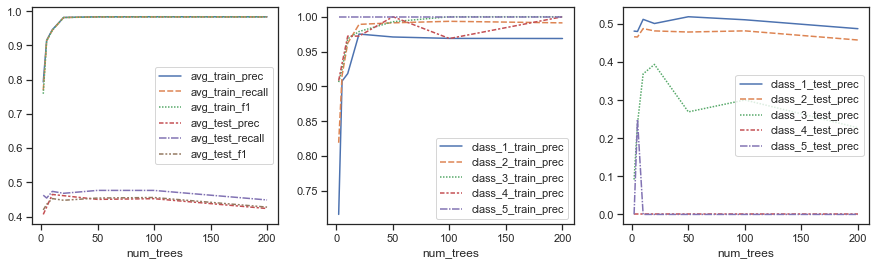

In [288]:
result_df = pd.DataFrame(result)
result_df.set_index('num_trees', inplace=True)
fig, axes = plt.subplots(1,3, figsize = (15,4))
sns.lineplot(ax=axes[0], data=result_df[['avg_train_prec','avg_train_recall','avg_train_f1','avg_test_prec','avg_test_recall','avg_test_f1']])
sns.lineplot(ax=axes[1], data=result_df[['class_1_train_prec','class_2_train_prec','class_3_train_prec','class_4_train_prec','class_5_train_prec']])
sns.lineplot(ax=axes[2], data=result_df[['class_1_test_prec','class_2_test_prec','class_3_test_prec','class_4_test_prec','class_5_test_prec']])
metrics[5].describe()